# Reproduction Instructions

Others
1. Navigate to `/scripts/`
2. Execute `get_suburbs_shp.py`
3. Execute `/notebooks/PTVdataProcessing.ipynb`

House Speaking Same
1. Navigate to `/scripts/housespeakingsame`
2. Execute `scrape_house_speakingsame_suburbs.py`
3. Execute `preprocess_house_speakingsame_suburbs.py`
4. Execute `scrape_house_speakingsame_schools.py`

In [1]:
import pandas as pd
import geopandas as gpd
from glob import glob
import folium
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.geometry import Point

TOP_SUB_DATA_DIR = "../data/curated/housespeakingsame/top/"
SCHOOLS_PATH = "../data/raw/housespeakingsame/schools/top_schools.csv"
PTV_PATH = '../data/curated/PTV_stations_count_by_suburb.csv'
shp_file = "../data/raw/suburbs/SAL_2021_AUST_GDA2020.shp"
ENTERTAINMENT_PATHS = {
    'shop': '../data/raw/openstreetmap/shopping_centres_victoria.csv',
    'theater': '../data/raw/openstreetmap/theaters_victoria_info.csv',
    'park': '../data/raw/openstreetmap/park_victoria.csv'
}

In [2]:
sf = gpd.read_file(shp_file)
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf = sf.query("STE_NAME21=='Victoria'")
sf['suburb'] = sf['SAL_NAME21'].str.replace(' \([^\(\)]+\)', '').apply(lambda x: 'Preston West' if x=='Preston' else x)
sf = sf[['suburb','geometry']].dropna()

<ipython-input-2-82bc9bdd220b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  sf['suburb'] = sf['SAL_NAME21'].str.replace(' \([^\(\)]+\)', '').apply(lambda x: 'Preston West' if x=='Preston' else x)


In [3]:
entertainment = pd.DataFrame()
for name, path in ENTERTAINMENT_PATHS.items():
    ent_df = pd.read_csv(path, index_col=0)
    ent_df['type'] = name
    entertainment = pd.concat([entertainment, ent_df])
entertainment = entertainment.drop_duplicates()

In [4]:
from collections import defaultdict
def count_entertainment(polygon):
    """
    Counts entertainment features inside a suburb polygon
    """
    dd = defaultdict(lambda: 0)
    for lng, lat, name in entertainment[['lng','lat','type']].values:
        dd[name] += int(polygon.contains(Point(lng,lat)))
    return pd.DataFrame(dd, index=[0])

In [5]:
%%time
sf[['shop','theater','park']] = pd.concat(sf['geometry'].apply(count_entertainment).values).values.tolist()

CPU times: user 18.9 s, sys: 10.7 ms, total: 18.9 s
Wall time: 19.5 s


In [6]:
sf['entertainment'] = sf[['shop','theater','park']].sum(axis=1)

In [7]:
sub_df = pd.DataFrame(columns = ['suburb'])
for p in glob(TOP_SUB_DATA_DIR + '*'):
    name = p.split('/')[-1].split('.')[0]
    d = pd.read_csv(p, index_col=0)[['suburb','rank','value']]
    d[name] = d['value']
    d[name + '_rank'] = d['rank']
    d = d.drop(['value', 'rank'], axis=1)
    sub_df = sub_df.merge(d, on='suburb', how='outer')
sub_df = sub_df.sort_values('rent_rank')

In [8]:
schools = pd.read_csv(SCHOOLS_PATH)

In [9]:
school_ranks = schools.groupby('suburb')['rank'].agg(['min','mean','max']).reset_index().set_index('suburb')
school_ranks.columns = ['school_rank_' + c for c in school_ranks.columns]
school_counts = schools.groupby('suburb')['type'].value_counts().reset_index(name='count').pivot('suburb','type','count').reset_index().fillna(0)
school_counts['total'] = school_counts.drop('suburb', axis=1).sum(axis=1)
school_counts = school_counts.sort_values('total').set_index('suburb')
school_counts.columns = ['schools_' + c for c in school_counts.columns]

In [10]:
sub_schools = school_counts.merge(school_ranks, left_index=True, right_index=True, how='outer').reset_index()

In [11]:
ptv = pd.read_csv(PTV_PATH, index_col=0).fillna(0)
ptv['suburb'] = ptv['suburb'].str.lower().str.capitalize()

In [12]:
ptv.columns = ['suburb', 'Train', 'Tram', 'Bus', 'Total Stations']

In [13]:
sub = sub_df.merge(sub_schools, on='suburb', how='outer').merge(ptv, on='suburb', how='left').merge(sf, on='suburb', how='left')

In [14]:
fill0_cols = ['rented', 'education', 'turnover', 'owned', 'houses', 'occupation',
              'flats', 'purchased', 'schools_Combined', 'schools_Primary', 'schools_Secondary',
              'schools_total', 'Train', 'Tram', 'Bus', 'Total Stations', 'shop', 'theater', 'park', 'entertainment']
sub[fill0_cols] = sub[fill0_cols].fillna(0)
sub = sub.rename({'suburb': 'Suburb'}, axis=1)

In [15]:
# Assign ranks & percentiles to suburb features
torank_cols = ['schools_Combined','schools_Primary','schools_Secondary',
           'schools_total','Train','Tram','Bus','Total Stations', 'shop', 'theater', 'park', 'entertainment',
          'rent_rank','sold_rank'] # reverse rent and sold value ranks, since lower is more affordable
topct_cols = ['education','income','sold','rent','occupation','schools_Combined','schools_Primary','schools_Secondary',
              'schools_total','Train','Tram','Bus','Total Stations','shop','theater','park','entertainment']

for col in torank_cols:
    sub[col + '_rank'] = sub[col].rank(method='min', ascending=False)
for col in topct_cols:
#     sub[col + '_score'] = int(col in ['sold','rent']) - (sub[col] / sub[col].max())
    sub[col + '_pct'] = 1 - sub[col].rank(method='min', pct=True, ascending=col not in ['sold','rent'])

# Analyses

In [125]:
m = folium.Map(location=(-37.810003,144.962594), tiles="Stamen Terrain", zoom_start=16)
sf_df = gpd.GeoDataFrame(sf)
geoJSON = sf_df[['suburb','geometry']].dropna().drop_duplicates().to_json()
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot    
    fill_opacity=0.1
)

c.add_to(m)
m.save("../plots/suburb_boundaries.html")

In [16]:
def p(r,c,w,h):
    return plt.subplots(r,c,figsize=(w,h))

## Entertainment

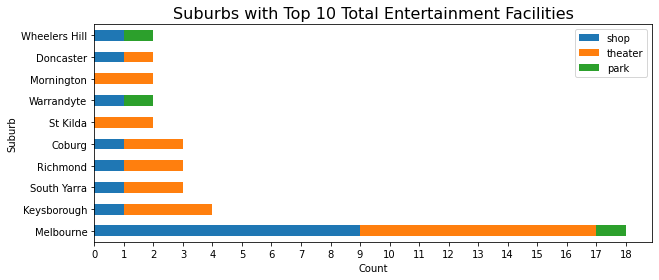

In [39]:
fig, ax = p(1,1,10,4)
sub.nlargest(10, 'entertainment').plot(kind='barh', x='Suburb', y=['shop','theater','park'], stacked=True,
                                       title='Suburbs with Top 10 No. Entertainment Facilities',ax=ax)
plt.title('Suburbs with Top 10 Total Entertainment Facilities', size=16)
ax.set_xlabel("Count")
ax.set_xticks(list(range(19)))

In [18]:
melb_poly = sf.loc[sf['suburb']=='Melbourne']['geometry'].values[0]
melb_ent = entertainment.loc[entertainment.apply(lambda d: melb_poly.contains(Point(d['lng'], d['lat'])), axis=1)]

In [70]:
melb_ent

,name,geocode_name,street,neighborhood,city,county,lng,lat,address,type
index,,,,,,,,,,
1,Melbourne Central,Melbourne Central,La Trobe Street,Melbourne,NaN,NaN,144.962594,-37.810003,"Melbourne Central, La Trobe Street, Melbourne,...",shop
5,Bourke Street Mall,Bourke Street Mall,Centrepoint,Melbourne,NaN,NaN,144.965298,-37.813554,"Bourke Street Mall, Centrepoint, Melbourne, Ci...",shop
168,Galleria Melbourne,Galleria,Galleria Arcade,Melbourne,NaN,NaN,144.962883,-37.814796,"Galleria, Galleria Arcade, Melbourne, City of ...",shop
213,QV Melbourne,QV,QV Square,Melbourne,NaN,NaN,144.965707,-37.810676,"QV, QV Square, Melbourne, City of Melbourne, G...",shop
236,Emporium Melbourne,Emporium,287,Lonsdale Street,NaN,NaN,144.963934,-37.812488,"Emporium, 287, Lonsdale Street, Melbourne, Cit...",shop
245,Collins Place,Collins Place,Melbourne,City of Melbourne,NaN,NaN,144.973194,-37.814146,"Collins Place, Melbourne, City of Melbourne, G...",shop
249,St. Collins Lane,St. Collins Lane,260,Collins Street,NaN,NaN,144.964981,-37.815340,"St. Collins Lane, 260, Collins Street, Melbour...",shop
255,Royal Arcade,Royal Arcade,Melbourne,City of Melbourne,NaN,NaN,144.964091,-37.814554,"Royal Arcade, Melbourne, City of Melbourne, Gr...",shop
267,Melbourne's GPO,Melbourne's GPO,350,Bourke Street,NaN,NaN,144.963301,-37.813658,"Melbourne's GPO, 350, Bourke Street, Melbourne...",shop


In [96]:
m = folium.Map(location=(-37.810003,144.962594), tiles="Stamen Terrain", zoom_start=16)

def icon_map(key):
    # dictionaries don't work with icons, workaround
    if key=='shop': return folium.Icon(icon='shopping-cart', prefix='fa')
    elif key=='park': return folium.Icon(icon='tree', prefix='fa', color='green')
    elif key=='theater': return folium.Icon(icon='film', prefix='fa', color='red')
    else: return

for ent, lng, lat in melb_ent[['type','lng','lat']].values:
    icon = icon_map(ent)
    m.add_child(
        folium.Marker(location=(lat,lng), icon=icon)
    )
m

## Public Transport

Text(0.5, 1.0, 'Suburbs with Top 10 Total PTV Stations')

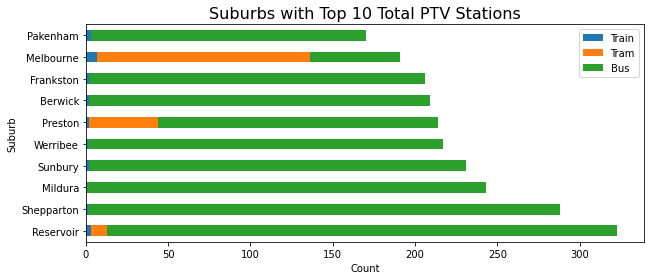

In [20]:
fig, ax = p(1,1,10,4)
sub.nlargest(10, 'Total Stations')[['Suburb','Train','Tram','Bus','Total Stations']].plot(
    kind='barh', x='Suburb', y=['Train','Tram','Bus'], stacked=True, title='Suburbs with Top 10 Total PTV Station Counts', ax=ax)
plt.xlabel('Count')
plt.title('Suburbs with Top 10 Total PTV Stations', size=16)

Text(0.5, 1.0, 'Suburbs with Top 10 Tram Stations')

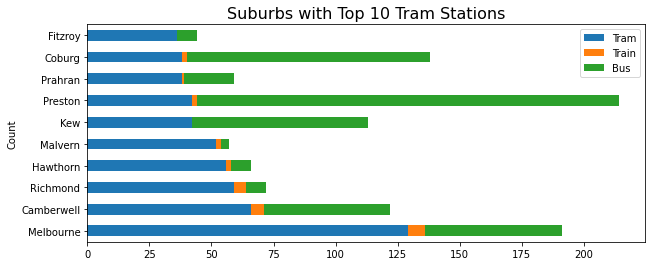

In [21]:
fig, ax = p(1,1,10,4)
sub.nlargest(10, 'Tram')[['Suburb','Train','Tram','Bus','Total Stations']].plot(
    kind='barh', x='Suburb', y=['Tram','Train','Bus'], stacked=True, title='Suburbs with Top 10 Tram Station Counts', ax=ax)
plt.ylabel('Count')
plt.title('Suburbs with Top 10 Tram Stations', size=16)

## Education

In [22]:
educ = sub[['Suburb', 'education', 'education_rank', 'schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max']].copy()
educ.columns = ['Suburb', 'Tertiary', 'Tertiary Rank', 'Combined', 'Primary',
       'Secondary', 'Schools', 'HS Rank (min)',
       'HS Rank (avg)', 'HS Rank (max)']

Text(0.5, 1.0, 'Suburbs with Top 10 Tertiary/University Education Rates')

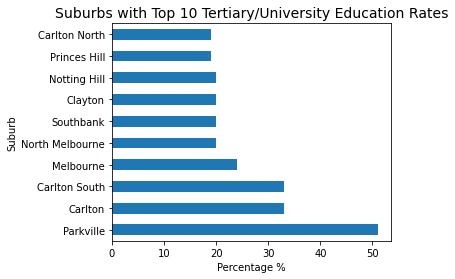

In [23]:
fig, ax = p(1,1,5,4)
educ.nlargest(10, 'Tertiary').plot(kind='barh', x='Suburb', y='Tertiary', title='Top Tertiary/University Education %', ax=ax)
plt.xlabel('Percentage %')
ax.get_legend().remove()
plt.title('Suburbs with Top 10 Tertiary/University Education Rates', size=14)

Text(0.5, 1.0, 'Suburbs with Top 10 Total Schools')

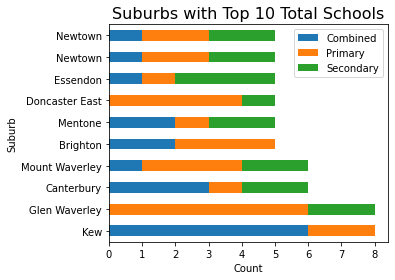

In [24]:
fig, ax = p(1,1,5,4)
educ.nlargest(10, "Schools").plot(kind='barh', x='Suburb', y=['Combined','Primary','Secondary'], stacked=True, ax=ax)
plt.xlabel('Count')
plt.title("Suburbs with Top 10 Total Schools", size=16)

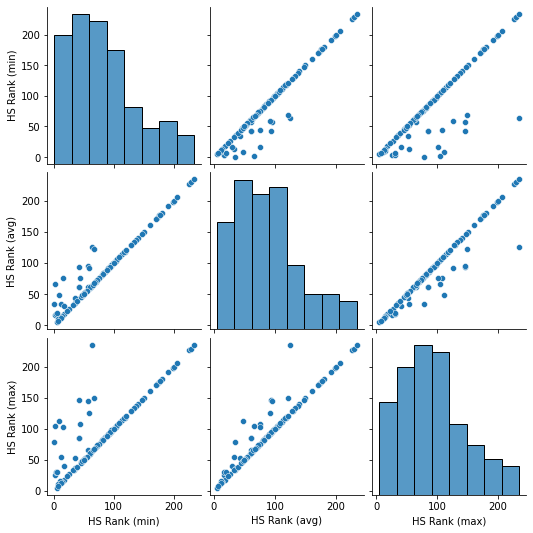

In [25]:
sns.pairplot(educ[['HS Rank (min)', 'HS Rank (avg)', 'HS Rank (max)']])

Text(0.5, 1.0, 'Suburbs with Top 10 High School Rankings')

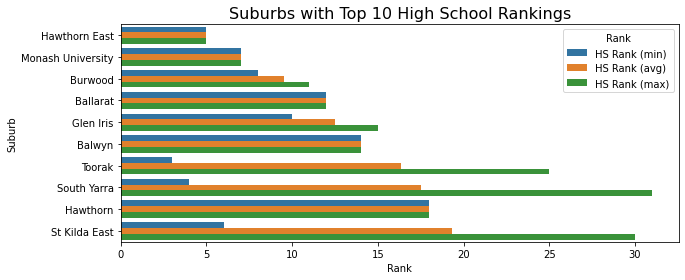

In [26]:
fig, ax = p(1,1,10,4)
sns.barplot(
    data=educ.nsmallest(10, 'HS Rank (avg)')[
        ['Suburb','HS Rank (min)','HS Rank (avg)','HS Rank (max)']].melt(
        'Suburb', var_name='Rank'), 
    y='Suburb', x='value', hue='Rank')
plt.xlabel("Rank")
plt.title("Suburbs with Top 10 High School Rankings", size=16)

## Affordability

Text(0.5, 1.0, 'Suburbs with Top 10 Affordable Rent')

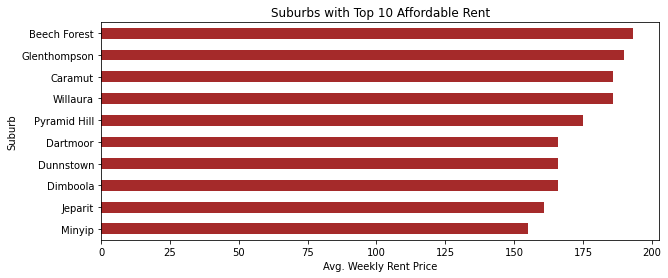

In [27]:
fig, ax = p(1,1,10,4)
sub.nsmallest(10, 'rent').plot(kind='barh', x='Suburb', y='rent', ax=ax, color='brown')
ax.get_legend().remove()
ax.set_xlabel("Avg. Weekly Rent Price")
plt.title("Suburbs with Top 10 Affordable Rent")

Text(0.5, 1.0, 'Suburbs with Top 10 Affordable Properties')

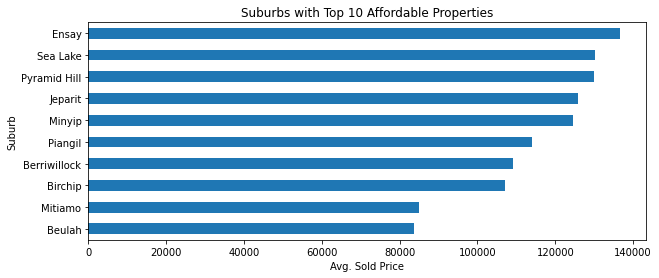

In [28]:
fig, ax = p(1,1,10,4)
sub.nsmallest(10, 'sold').plot(kind='barh', x='Suburb', y='sold', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Avg. Sold Price")
plt.title("Suburbs with Top 10 Affordable Properties")

## Employment & Income

Text(0.5, 1.0, 'Suburbs with Top 10 Rates of Occupation Professionals')

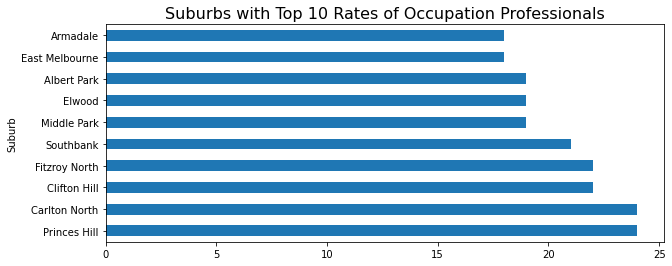

In [29]:
fig,ax = p(1,1,10,4)
emp = sub[['Suburb','occupation','income']].copy()
emp.columns = ['Suburb', 'Professionals %', 'Median Weekly Income']
# sns.barplot(data=emp.nlargest(10, 'Professionals %'), y='Suburb', x='Professionals %')
emp.nlargest(10, 'Professionals %').plot(kind='barh', x='Suburb', y='Professionals %', ax=ax)
ax.get_legend().remove()
plt.title("Suburbs with Top 10 Rates of Occupation Professionals", size=16)

Text(0.5, 1.0, 'Suburbs with Top 10 Median Weekly Income')

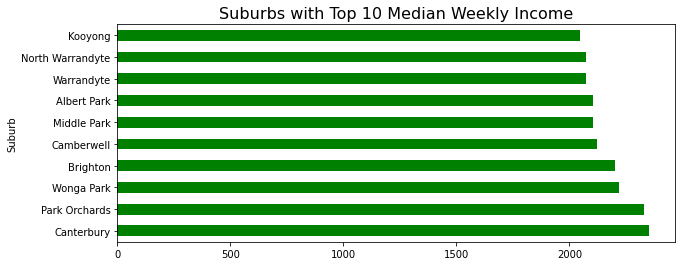

In [30]:
fig, ax = p(1,1,10,4)
emp.nlargest(10, 'Median Weekly Income').plot(kind='barh', x='Suburb', y='Median Weekly Income', ax=ax, color='green')
ax.get_legend().remove()
plt.title("Suburbs with Top 10 Median Weekly Income", size=16)

# Aggregate Analyses

💡 dynamic weights on ranks!

Normalise by area..???

In [31]:
sf['geometry'].apply(lambda x: x.area)

4544    0.033162
4545    0.000178
4546    0.000159
4547    0.001107
4548    0.007381
          ...   
7483    0.003174
7484    0.000906
7485    0.005404
7486    0.001808
7487    0.026011
Name: geometry, Length: 2944, dtype: float64

In [32]:
pct_cols = [
    'education_pct', 'income_pct', 'sold_pct', 'rent_pct', 'occupation_pct', 
    'schools_Combined_pct', 'schools_Primary_pct', 'schools_Secondary_pct', 
    'schools_total_pct', 'Train_pct', 'Tram_pct',
    'Bus_pct', 'Total Stations_pct', 
    'shop_pct', 'theater_pct', 'park_pct',
    'entertainment_pct'
]

pct = sub[['Suburb'] + pct_cols].copy()
pct[pct_cols] = pct[pct_cols].fillna(pct[pct_cols].mean()) # mean imputation

pct.columns = [
    'Suburb', 'Education', 'Income', 'Sold', 'Rent', 'Professionals',
    'Combined', 'Primary', 'Secondary',
    'Schools', 'Train', 'Tram',
    'Bus', 'Stations',
    'Shop', 'Theater', 'Park',
    'Entertainment']

In [33]:
mean_cols = [
    'Education', 'Income', 'Sold', 'Rent', 'Professionals',
    #'Combined', 'Primary', 'Secondary',
    'Schools', 'Train', 'Tram',
    'Bus', 'Stations',
    #'Shop', 'Theater', 'Park',
    'Entertainment']

pct_top10 = pct[['Suburb'] + mean_cols].copy()
pct_top10['Mean'] = pct_top10[mean_cols].mean(axis=1)
# pct_top10['median_score'] = pct_top10[mean_cols].quantile(0.5, axis=1)

pct_top10 = pct_top10.nsmallest(10, 'Mean').set_index('Suburb') * 100
pct_top10.style.background_gradient().format("Top {:.1f}%")

,Education,Income,Sold,Rent,Professionals,Schools,Train,Tram,Bus,Stations,Entertainment,Mean
Suburb,,,,,,,,,,,,
Melbourne,Top 0.2%,Top 71.5%,Top 52.7%,Top 71.1%,Top 10.4%,Top 1.8%,Top 0.0%,Top 0.0%,Top 6.9%,Top 0.6%,Top 0.0%,Top 19.6%
Northcote,Top 4.8%,Top 12.5%,Top 91.3%,Top 91.3%,Top 3.8%,Top 3.8%,Top 0.2%,Top 1.0%,Top 4.1%,Top 2.6%,Top 5.1%,Top 20.1%
Richmond,Top 3.8%,Top 6.1%,Top 87.7%,Top 92.3%,Top 5.1%,Top 3.8%,Top 0.2%,Top 0.1%,Top 21.7%,Top 5.0%,Top 0.3%,Top 20.6%
Hawthorn,Top 0.7%,Top 9.6%,Top 98.3%,Top 95.6%,Top 0.9%,Top 13.1%,Top 2.8%,Top 0.2%,Top 21.7%,Top 5.9%,Top 5.1%,Top 23.1%
Essendon,Top 10.7%,Top 11.9%,Top 90.1%,Top 81.8%,Top 7.1%,Top 0.6%,Top 0.8%,Top 1.1%,Top 2.8%,Top 1.8%,Top 99.9%,Top 28.1%
Camberwell,Top 4.8%,Top 0.6%,Top 97.3%,Top 96.0%,Top 1.7%,Top 1.8%,Top 0.2%,Top 0.1%,Top 7.9%,Top 1.7%,Top 99.9%,Top 28.4%
Kew,Top 3.8%,Top 1.6%,Top 98.1%,Top 96.2%,Top 1.7%,Top 0.1%,Top 99.9%,Top 0.4%,Top 4.5%,Top 2.2%,Top 5.1%,Top 28.5%
Brunswick,Top 1.0%,Top 23.6%,Top 83.9%,Top 87.4%,Top 7.1%,Top 99.9%,Top 0.8%,Top 1.0%,Top 4.7%,Top 2.8%,Top 5.1%,Top 28.9%
Eltham,Top 14.9%,Top 3.3%,Top 81.5%,Top 82.0%,Top 7.1%,Top 3.8%,Top 12.5%,Top 99.9%,Top 7.3%,Top 8.1%,Top 5.1%,Top 29.6%


In [148]:
pct_export = pct.copy().set_index('Suburb') * 100
pct_export['Mean'] = pct_export.mean(axis=1)
pct_export.columns = ['Uni/Tertiary Education', 'Income', 'Buy Price', 'Rent Price', 'Professionals', 'Combined Schools',
       'Primary Schools', 'Secondary Schools', 'Total Schools', 'Trains', 'Trams', 'Buses', 'Total Stations',
       'Shops', 'Theaters', 'Parks', 'Total Entertainments', 'Mean']
pct_export.to_csv("../liveability_app/data.csv")

In [147]:
pct_export.columns

Index(['Education', 'Income', 'Sold', 'Rent', 'Professionals', 'Combined',
       'Primary', 'Secondary', 'Schools', 'Train', 'Tram', 'Bus', 'Stations',
       'Shop', 'Theater', 'Park', 'Entertainment', 'Mean'],
      dtype='object')

In [135]:
import plotly.express as px

In [140]:
px.imshow

<function plotly.express._imshow.imshow(img, zmin=None, zmax=None, origin=None, labels={}, x=None, y=None, animation_frame=None, facet_col=None, facet_col_wrap=None, facet_col_spacing=None, facet_row_spacing=None, color_continuous_scale=None, color_continuous_midpoint=None, range_color=None, title=None, template=None, width=None, height=None, aspect=None, contrast_rescaling=None, binary_string=None, binary_backend='auto', binary_compression_level=4, binary_format='png', text_auto=False)>

In [145]:
px.imshow(pct_export.head(5).round(2))#, text_auto=True)

# Archived

In [35]:
liveability_features = ['education', 'income', 'occupation', 'school_min', 'school_mean', 'school_max',
 'schools_Combined', 'schools_Primary', 'schools_Secondary', 'schools_total', 'Train', 'Tram',
 'Bus', 'Total Stations', 'rent', 'sold', 'shop', 'theater', 'park', 'entertainment'
]
rank_cols = [
    'education_rank','income_rank','occupation_rank','school_rank_min',
    'school_rank_mean','school_rank_max', 'schools_Combined_rank', 'schools_Primary_rank',
    'schools_Secondary_rank', 'schools_total_rank', 'Train_rank',
    'Tram_rank', 'Bus_rank', 'Total Stations_rank', 'rent_rank_rank', 'sold_rank_rank',
    'shop_rank','theater_rank','park_rank','entertainment_rank'
]
agg_rank = sub[['Suburb'] + rank_cols].copy()

agg_rank[rank_cols] = agg_rank[rank_cols].fillna(agg_rank[rank_cols].mean().round(0)).astype(int)
agg_rank['median_rank'] = agg_rank[rank_cols].quantile(0.5, axis=1)
agg_rank['mean_rank'] = agg_rank[rank_cols].mean(axis=1)
agg_rank.nsmallest(10, 'median_rank')

,Suburb,education_rank,income_rank,occupation_rank,school_rank_min,school_rank_mean,school_rank_max,schools_Combined_rank,schools_Primary_rank,schools_Secondary_rank,...,Bus_rank,Total Stations_rank,rent_rank_rank,sold_rank_rank,shop_rank,theater_rank,park_rank,entertainment_rank,median_rank,mean_rank
316,Melbourne,3,190,13,1,34,79,6,125,10,...,98,9,778,682,1,1,1,1,9.5,102.50
40,South Yarra,8,36,5,4,17,31,14,8,10,...,659,665,1057,1265,3,3,10,3,12.5,201.80
51,Balwyn,12,53,8,14,14,14,14,3,54,...,107,75,1046,1271,57,8,10,18,16.0,149.70
41,Kew,11,9,6,17,30,40,1,8,54,...,65,32,1056,1270,57,8,10,18,17.5,144.05
47,Hawthorn,6,43,5,18,18,18,14,125,54,...,299,84,1049,1272,57,8,10,18,18.0,158.60
52,Glen Iris,12,13,6,10,12,15,6,8,54,...,659,665,1045,1257,57,26,10,76,20.5,208.45
43,Camberwell,12,5,6,70,70,70,60,8,10,...,111,24,1054,1259,57,26,10,76,25.0,147.40
6,Toorak,11,12,7,3,16,25,2,125,54,...,216,106,1091,1289,57,26,10,76,25.5,159.80
202,Essendon,14,51,11,16,75,102,14,29,1,...,39,27,895,1166,57,26,10,76,26.5,131.85
36,Armadale,9,32,5,26,26,27,6,125,54,...,217,121,1061,1248,57,26,10,76,27.5,159.00


In [ ]:
from sklearn.decomposition import PCA
reducer = PCA(n_components=2)
pct_pca = pd.DataFrame(reducer.fit_transform(pct[pct_cols]), columns=['PC_1', 'PC_2'])
pct_pca['Suburb'] = pct['Suburb']
plt.subplots(1,1,figsize=(20,7))
sns.scatterplot(data=pct_pca, x='PC_1', y='PC_2', color='black', alpha=0.2)#, hue='Suburb')
sns.scatterplot(data=pct_pca.loc[pct_pca['Suburb'].isin(agg_rank.nsmallest(10, 'median_rank')['Suburb'])], x='PC_1', y='PC_2', hue='Suburb')

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.pairplot(sub, x_vars=['rented', 'rented_rank', 'education', 'education_rank',
       'turnover', 'turnover_rank', 'owned', 'owned_rank', 'houses',
       'houses_rank', 'income', 'income_rank', 'sold', 'sold_rank'], y_vars = ['rent_rank'])
plt.show()
sns.pairplot(sub, x_vars=['occupation', 'occupation_rank', 'flats', 'flats_rank',
       'purchased', 'purchased_rank', 'schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max'], y_vars = ['rent_rank'])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

clf = Pipeline([StandardScaler(), Lass()])
clf.fit()

In [ ]:
plt.subplots(1,1,figsize=(10,7))
sns.heatmap(sub.corr(method='spearman'))

In [ ]:
schools_all = pd.read_excel('../data/raw/abs_data/education.xlsx', sheet_name = 3, skiprows = 4)

schools = schools_all.loc[schools_all['State/Territory'] == 'b Vic.']

In [ ]:
schools